<a href="https://colab.research.google.com/github/drjaehongmin/hello-world/blob/master/BERT_FineTune_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Jae-Hong Min
# Last Edit 05 Aug 2021
# Initially Based Off of: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/ but heavily modified

# Parameters Panel
# Special token switch will control whether special characters are added during the pretrain / NER train in the custom tokenizers
# NER = FALSE
# Pretrain = TRUE!
special_token_switch = False

# Define Batch Size and Maximum Length of text
# Remember to change this to 256 as per EDA for final run!!!
MAX_LEN = 256
bs = 32

# Import necessary libraries
from google.colab import drive
from google.colab import files
# Mounts the Google Drive

drive.mount('/content/drive')

#=================================#
# Experimental Parameters         #
#=================================#

tokenizer_file_path = '/content/drive/MyDrive/Academic Research/W266 Final Project/test/'
bert_model_selected = '/content/drive/MyDrive/Academic Research/W266 Final Project/models/NurseBERT_small'

tokenizer_file_path = "bert-base-cased"
#bert_model_selected = "bert-base-cased"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# NER fine tuning and training

## Initialization of Code

In [2]:
# Install necessary packages for the program
!pip install transformers
!pip install seqeval

     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 61.6 MB/s 
     |████████████████████████████████| 3.3 MB 31.0 MB/s 
     |████████████████████████████████| 895 kB 63.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 43 kB 970 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=58064a61f65d3eeb60b31091e3685cfd7f70dffdf5c7d66ee47c7ac42bb0bd85
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [3]:

from tqdm import tqdm, trange

import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, accuracy_score

In [4]:
# Loads the training data set
data = pd.read_csv("/content/drive/MyDrive/Academic Research/W266 Final Project/Test Sets/NCBI-disease/train.csv", encoding="latin1").fillna(method="ffill")

In [5]:
# Sanity Check
#data[0:100]

In [6]:
# Creates the appropriate Class to load the text information
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
# Create the different variables
# Separates the data into the text and labels sets
getter = SentenceGetter(data)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[s[2] for s in sentence] for sentence in getter.sentences]

In [8]:
# Creates the label dictionary
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [9]:
# Loads device as GPU
# Sanity check too
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [54]:
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Academic Research/W266 Final Project/test/')
bert = BertTokenizer.from_pretrained("bert-base-cased")

In [88]:
bert.tokenize("Pseudopseudohypoparathyroidism")

['P',
 '##se',
 '##udo',
 '##pse',
 '##udo',
 '##hy',
 '##pop',
 '##ara',
 '##thy',
 '##roid',
 '##ism']

In [89]:
tokenizer.tokenize("Pseudopseudohypoparathyroidism")

['[UNK]']

## Tokenizer - Original BERT Base NER fine tuning

In [11]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [12]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [13]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [14]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [15]:
input_ids[1]

array([ 1109,  8050, 26601, 21943,  2285,   185, 23415,  5674,  4863,
        1884,  2646,   113, 10997,  1658,   114,   189, 27226,   118,
       17203,  1766,  4592,  7451,  1103,   160,  2227, 25498, 13548,
        1118,  5071,   170,  2703,  1114,   176,  1193,  2528,  4915,
         188, 26588,  6530, 24779,   124, 16632,  1161,   113,   144,
        1708,  2428,   118,   124, 16632,  1161,   114,   117,   170,
       16594,   120,  5880,  1394,  1105, 11933, 20127, 10430,   119,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [16]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [17]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [18]:
print(type(tags))
print(type(input_ids))
print(type(attention_masks))
print((tags.shape))
print((input_ids.shape))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
(5424, 256)
(5424, 256)


In [19]:
print(tags[0:100])
print(input_ids[0:100])

[[2 2 2 ... 3 3 3]
 [2 1 1 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 ...
 [1 1 1 ... 3 3 3]
 [2 2 2 ... 3 3 3]
 [2 2 2 ... 3 3 3]]
[[  146 11951  5783 ...     0     0     0]
 [ 1109  8050 26601 ...     0     0     0]
 [  138  1887 10978 ...     0     0     0]
 ...
 [22878 13335  9014 ...     0     0     0]
 [ 1130  1142  1266 ...     0     0     0]
 [17635  3584  1104 ...     0     0     0]]


## Initialization of Model - Fine Turning NER

In [20]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [21]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [22]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [23]:
import transformers
from transformers import BertForTokenClassification, AdamW

In [24]:
model = BertForTokenClassification.from_pretrained(
    bert_model_selected,
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at /content/drive/MyDrive/Academic Research/W266 Final Project/models/NurseBERT_small were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized fro

In [25]:
model.cuda();


In [26]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [27]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Run Model - Fine Turning NER

In [29]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.20011705087096082


Epoch:  33%|███▎      | 1/3 [02:00<04:01, 120.70s/it]

Validation loss: 0.09375454540200093
Validation Accuracy: 0.9684780182994868
Average train loss: 0.060762904584407806


Epoch:  67%|██████▋   | 2/3 [04:01<02:00, 120.64s/it]

Validation loss: 0.06790181216509904
Validation Accuracy: 0.9777393438964517
Average train loss: 0.033439716366819694


Epoch: 100%|██████████| 3/3 [06:01<00:00, 120.57s/it]

Validation loss: 0.07281822367461727
Validation Accuracy: 0.9772930149520196


## Validation and test

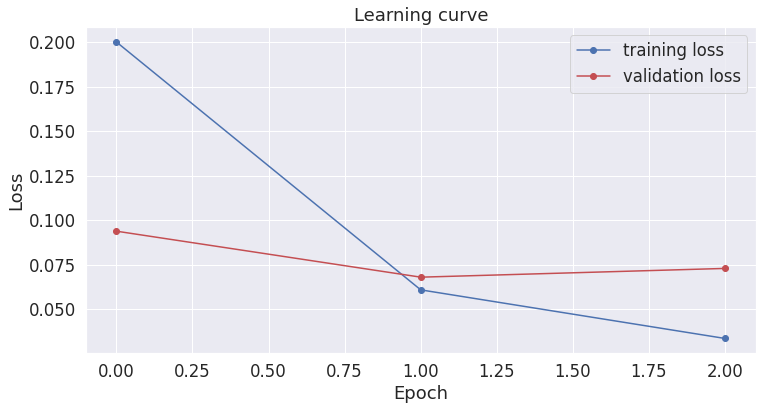

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


## Validation and Scoring

In [31]:
# Loads the necessary library
from sklearn import metrics

In [32]:
# Loads the test data
test = pd.read_csv("/content/drive/MyDrive/Academic Research/W266 Final Project/Test Sets/NCBI-disease/train.csv", encoding="latin1").fillna(method="ffill")

# Converts the test set to appropriate labels and sentences
getter = SentenceGetter(test)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[s[2] for s in sentence] for sentence in getter.sentences]

In [33]:
pred_all = []


for sentence, label in zip(sentences, labels):
  tokenized_sentence = tokenizer.encode(sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

  # This is done to remove start and finish
  tested_y = np.array(new_labels)
  pred_all.append(tested_y[1:-1])

In [34]:
flat_list = [item for sublist in pred_all for item in sublist]

In [35]:
actual_all = [item for sublist in labels for item in sublist]

In [36]:
test_num = [tag2idx[i] for i in flat_list]
pred_num = [tag2idx[i] for i in actual_all]

# F1 Score

In [37]:
print("Macro:" + str(metrics.f1_score(test_num, pred_num, average = 'macro')))
print("Micro:" + str(metrics.f1_score(test_num, pred_num, average = 'micro')))
print("Weighted:" + str(metrics.f1_score(test_num, pred_num, average = 'weighted')))

Macro:0.7318928107736565
Micro:0.9535891408316813
Weighted:0.9603252803781699
